## Basic EDA

In [1]:
import boto3
import json

# S3 path
s3_path = 's3://capstone-project-legal-citation/datasets/adah_cases_full.json'

# Parse bucket and key from path
s3 = boto3.client('s3')
bucket_name = 'capstone-project-legal-citation'
file_key = 'datasets/adah_cases_full.json'

# Download or read directly from S3
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
data = json.loads(obj['Body'].read().decode('utf-8'))

print(f"Loaded {len(data)} records from {file_key}")

Loaded 15372 records from datasets/adah_cases_full.json


In [2]:
data[0].keys()

dict_keys(['ID', 'absolute_url', 'date_filed', 'case_name', 'case_full_name', 'docker_number', 'court_id', 'court', 'court_citation_string', 'court_jurisdiction', 'attorney', 'judge', 'panel_names', 'citation', 'lexisCite', 'neutralCite', 'cite_to', 'opinion_type', 'opinion', 'page_count', 'jurisdiction_inferred', 'Citing_Relationship'])

In [2]:
lengths = [len(item['opinion']) for item in data if 'opinion' in item and isinstance(item['opinion'], str)]

In [24]:
ct = 0 

for i in lengths:
    if i > 32000*4:
        ct += 1

print(ct)

579


In [25]:
print(f'{(len(lengths)-ct)/len(lengths)} of the opinions are less than 32k tokens')

0.9623341139734582 of the opinions are less than 32k tokens


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [12]:
# Set interval size
interval = 1000

# Convert to DataFrame
df = pd.DataFrame(lengths, columns=['value'])

# Create bins and labels
bins = range(0, max(lengths) + interval, interval)
labels = [f"{b}-{b+interval-1}" for b in bins[:-1]]

# Cut values into intervals
df['range'] = pd.cut(df['value'], bins=bins, labels=labels, include_lowest=True, right=True)

# Summarize counts per range
summary = df['range'].value_counts().sort_index().reset_index()
summary.columns = ['Range', 'Count']
summary = summary[summary['Count'] != 0]

print(summary)


                Range  Count
0               0-999    204
1           1000-1999     65
2           2000-2999     77
3           3000-3999     95
4           4000-4999     87
...               ...    ...
2623  2623000-2623999      1
2899  2899000-2899999      1
3184  3184000-3184999      1
3303  3303000-3303999      1
4248  4248000-4248999      1

[317 rows x 2 columns]


<Figure size 600x1000 with 0 Axes>

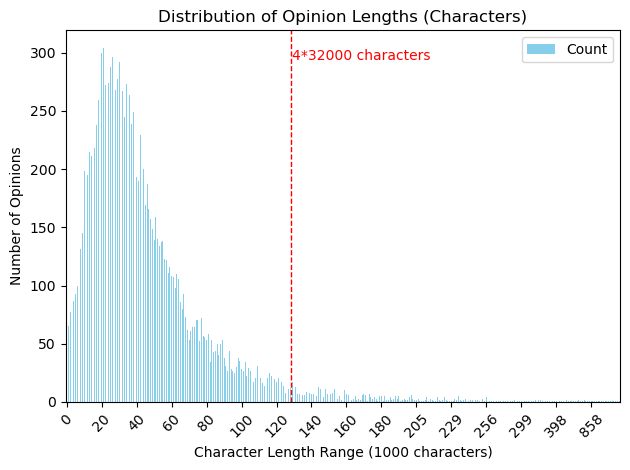

In [23]:
# Plot bar chart
plt.figure(figsize=(6, 10))
summary.plot(kind='bar', color='skyblue')
plt.xlabel('Character Length Range (by 1000 characters)')
plt.ylabel('Number of Opinions')
plt.title('Distribution of Opinion Lengths (Characters)')
plt.xticks(ticks=range(0, len(summary), 20), labels=summary.index[::20], rotation=45)

cutoff = 128000 / 1000 
plt.axvline(x=cutoff, color='red', linestyle='--', linewidth=1)
plt.text(cutoff + 1, plt.ylim()[1] * 0.95, '4*32000 characters', color='red', fontsize=10, va='top')
plt.tight_layout()
plt.show()

In [3]:
for i in range(10):
    print(data[i]['case_name'])

Hastings v. Papillion-LaVista School District
Kirkeberg v. Canadian Pacific Railway
Gilman v. Schwan's Home Service, Inc.
Elizabeth Rask v. Fresenius Medical
Rask v. Fresenius Medical Care North America
Singh v. George Washington University School of Medicine & Health Sciences
Connie Gretillat v. Care Initiatives
Connie M. Gretillat v. Care Initiatives
Bankston v. Chertoff
Napreljac v. John Q. Hammons Hotels, Inc.


## Year Distribution

In [7]:
!pip install matplotlib

Total citing decision dates: 2900

Decision date range:
  Min: 1925-06-18
  Q1 : 2000-09-18
  Q2 : 2009-02-09 (median)
  Q3 : 2016-07-26
  Max: 2025-10-08

Quartiles by year (approx):
  Q1 year: 2000
  Q2 year: 2009
  Q3 year: 2016


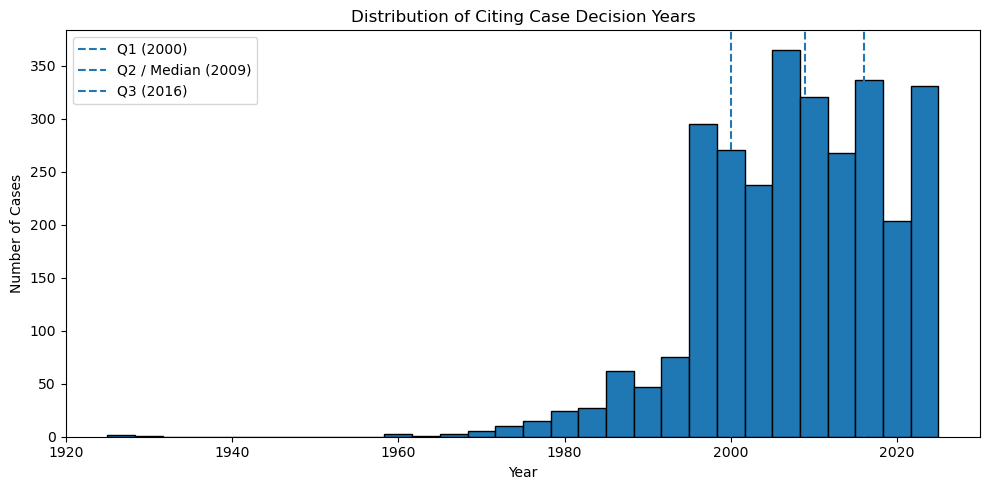

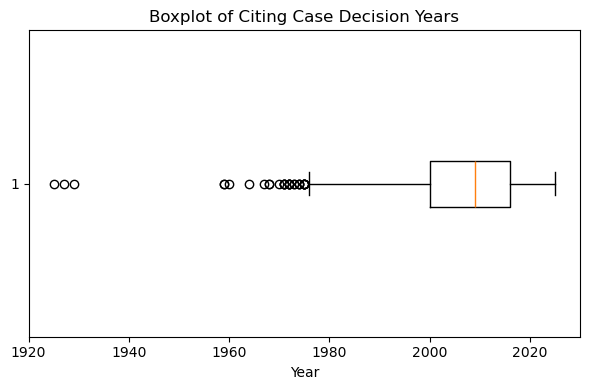

In [2]:
import os
import logging
from datetime import datetime
from typing import List

import pandas as pd
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from dotenv import load_dotenv

# ======================================================
# Setup: env + Neo4j driver
# ======================================================
for _n in ("neo4j", "neo4j.notifications", "neo4j.work.simple"):
    logging.getLogger(_n).setLevel(logging.ERROR)
os.environ.setdefault("NEO4J_DRIVER_LOG_LEVEL", "ERROR")

# .env is one level up, same as in your other scripts
load_dotenv("../.env", override=True)

NEO4J_URI       = os.getenv("NEO4J_URI")
NEO4J_USERNAME  = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD  = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE  = os.getenv("NEO4J_DATABASE", "neo4j")

if not (NEO4J_URI and NEO4J_USERNAME and NEO4J_PASSWORD):
    raise RuntimeError(
        "Missing Neo4j connection settings. "
        "Check ../.env for NEO4J_URI / NEO4J_USERNAME / NEO4J_PASSWORD."
    )

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

# ======================================================
# Cypher: same as in your labeling script
# ======================================================
Q_GET_TIME_DATES = """
MATCH (s:Case)-[:CITES_TO]->(:Case)
WHERE s.decision_date IS NOT NULL
RETURN DISTINCT s.decision_date AS decision_date
"""

# ======================================================
# Pull dates into a DataFrame
# ======================================================
with driver.session(database=NEO4J_DATABASE) as session:
    rows = session.run(Q_GET_TIME_DATES).data()

driver.close()

df = pd.DataFrame(rows)

if df.empty:
    raise RuntimeError("No decision_date values returned from Neo4j.")

# Convert to datetime (handles Neo4j date/datetime/strings)
df["decision_date"] = pd.to_datetime(df["decision_date"].astype(str), errors="coerce")
df = df.dropna(subset=["decision_date"]).reset_index(drop=True)

print(f"Total citing decision dates: {len(df)}")

# ======================================================
# Compute quartiles
# ======================================================
q1 = df["decision_date"].quantile(0.25)
q2 = df["decision_date"].quantile(0.50)  # median
q3 = df["decision_date"].quantile(0.75)
min_date = df["decision_date"].min()
max_date = df["decision_date"].max()

print("\nDecision date range:")
print(f"  Min: {min_date.date()}")
print(f"  Q1 : {q1.date()}")
print(f"  Q2 : {q2.date()} (median)")
print(f"  Q3 : {q3.date()}")
print(f"  Max: {max_date.date()}")

# If you want them as years only:
print("\nQuartiles by year (approx):")
print(f"  Q1 year: {q1.year}")
print(f"  Q2 year: {q2.year}")
print(f"  Q3 year: {q3.year}")

# ======================================================
# Plot: histogram of decision years with quartile lines
# ======================================================
df["year"] = df["decision_date"].dt.year

plt.figure(figsize=(10, 5))
plt.hist(df["year"], bins=30, edgecolor="black")

plt.axvline(q1.year, linestyle="--", linewidth=1.5, label=f"Q1 ({q1.year})")
plt.axvline(q2.year, linestyle="--", linewidth=1.5, label=f"Q2 / Median ({q2.year})")
plt.axvline(q3.year, linestyle="--", linewidth=1.5, label=f"Q3 ({q3.year})")

plt.title("Distribution of Citing Case Decision Years")
plt.xlabel("Year")
plt.ylabel("Number of Cases")
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================
# boxplot by year
# ======================================================
plt.figure(figsize=(6, 4))
plt.boxplot(df["year"].dropna(), vert=False)
plt.title("Boxplot of Citing Case Decision Years")
plt.xlabel("Year")
plt.tight_layout()
plt.show()
